In [2]:
import pandas as pd
import numpy as np

In [3]:
from tensorflow import keras
import tensorflow as tf

In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
from sklearn.model_selection import KFold

In [6]:
from IPython.display import clear_output

In [7]:
from matplotlib import pyplot as plt
import os, sys
sys.path.append(os.path.abspath("../../plots/"))
from plotter import plot_marginals

In [8]:
from itertools import product

In [9]:
from functools import reduce
import operator
def prod(iterable):
    return reduce(operator.mul, iterable, 1)
# from math import prod

In [10]:
from io import StringIO

In [11]:
import datetime

# Data preparation

Data can be found [here](http://mlr.cs.umass.edu/ml/machine-learning-databases/census-income/).

In [10]:
data = pd.read_csv(
#     "/cluster/scratch/bramva/deep-learning-course/data/census-income/census-income.data",
    "data/census-income.data",
    names=[
        "age",
        "workclass",
        "fnlwgt",
        "education",
        "education-num",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "capital-gain",
        "capital-loss",
        "hours-per-week",
        "native-country",
        "income",
    ],
)

In [11]:
categoricals = [
    "workclass",
    "education",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "native-country",
    "income",
]

In [12]:
data.describe(include="all")

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
count,32561.000000,32561,3.256100e+04,32561,32561.000000,32561,32561,32561,32561,32561,32561.000000,32561.000000,32561.000000,32561,32561
unique,NaN,9,NaN,16,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572720,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [13]:
data.iloc[0, :]

age                           39
workclass              State-gov
fnlwgt                     77516
education              Bachelors
education-num                 13
marital-status     Never-married
occupation          Adm-clerical
relationship       Not-in-family
race                       White
sex                         Male
capital-gain                2174
capital-loss                   0
hours-per-week                40
native-country     United-States
income                     <=50K
Name: 0, dtype: object

In [14]:
for categorical in categoricals:
    data[categorical] = LabelEncoder().fit_transform(data[categorical])
    values = data[categorical].unique()
    np.random.shuffle(values)
    data[categorical] = values[data[categorical]]

In [19]:
dataset = data.values

In [20]:
ordering = np.arange(dataset.shape[0])
np.random.shuffle(ordering)
dataset = dataset[ordering]

In [21]:
cutoff = round(dataset.shape[0] * .1)

In [22]:
train, labels = dataset[:, :-1], dataset[:, -1]

In [23]:
labels

array([0, 0, 0, ..., 0, 0, 0])

In [24]:
dataset.shape

(32561, 15)

# Model

In [26]:
def build_model(
    before_trainable_layers=[],
    random_layers=[],
    after_trainable_layers=[],
    regularization=1e-6,
):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(train.shape[1])))
    
    for i, layer_size in enumerate(before_trainable_layers):
        model.add(keras.layers.Dense(
            layer_size,
            activation="relu",
            kernel_regularizer=keras.regularizers.l2(regularization),
        ))
        
    for random_layer_size in random_layers:
        model.add(keras.layers.Dense(
            random_layer_size,
            activation="tanh",
            trainable=False,
        ))
    
    previous_size = random_layers[-1] if random_layers else before_trainable_layers[-1] if before_trainable_layers else train.shape[1]
    for i, layer_size in enumerate(after_trainable_layers):
        model.add(keras.layers.Dense(
            layer_size,
            activation="relu",
            kernel_regularizer=keras.regularizers.l2(regularization),
        ))
        
    model.add(keras.layers.Dense(2, activation='softmax'))
    return model

In [27]:
folds = 10

In [28]:
sizes = [10, 100]
max_random_depth = 2

before_options = [[], [100]]
random_options = [[size] * i for size in sizes for i in range(max_random_depth + 1)]
after_options = [[], [10]]

In [29]:
model_configurations = np.array(list(product(before_options, random_options, after_options)))
model_configurations = model_configurations.reshape(
    len(before_options),
    len(sizes),
    max_random_depth + 1,
    len(after_options),
    len((before_options, random_options, after_options)),
)
model_configurations.shape, prod(model_configurations.shape), prod(model_configurations.shape) * folds

((2, 2, 3, 2, 3), 72, 720)

In [30]:
results = np.zeros(model_configurations.shape[:-1] + (folds,))

In [51]:
for i, model_type in enumerate(model_configurations.reshape(-1, 3)):
    for j, (train_ids, test_ids) in enumerate(KFold(n_splits=folds, shuffle=True).split(np.arange(dataset.shape[0]))):
        num_of_random = len(model_type[1]);
        configuration = str(model_configurations.reshape(-1, 3)[i]).replace(" ", "")
        log_dir="logs/fit3/{}/{}/".format(configuration, j) + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        half_validate = round(len(test_ids) / 2)
        
        model = build_model(*model_type)
        model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
        model.fit(
            train[train_ids], labels[train_ids],
            64,
            epochs=100,
            shuffle=True,
            validation_data=(
                train[test_ids][:half_validate], labels[test_ids][:half_validate],
            ),
            callbacks=[
                keras.callbacks.EarlyStopping(
                    patience=5,
                    restore_best_weights=True,
                ),
                tensorboard_callback
            ],
        )
        
        score = model.evaluate(
            train[test_ids][round(len(test_ids) / 2):], labels[test_ids][round(len(test_ids) / 2):],
            verbose=0,
        )
        results.reshape(-1, folds)[i, j] = score[1]

Train on 29304 samples, validate on 1628 samples
Epoch 1/100
29304/29304 [==============================] - 1s 40us/sample - loss: 17320.0502 - accuracy: 0.7573 - val_loss: 151.0157 - val_accuracy: 0.2518
Epoch 2/100
29304/29304 [==============================] - 1s 41us/sample - loss: 85.0063 - accuracy: 0.6569 - val_loss: 51.7951 - val_accuracy: 0.5577
Epoch 3/100
29304/29304 [==============================] - 1s 38us/sample - loss: 41.2310 - accuracy: 0.6664 - val_loss: 25.7646 - val_accuracy: 0.7727
Epoch 4/100
29304/29304 [==============================] - 1s 22us/sample - loss: 20.6940 - accuracy: 0.6911 - val_loss: 4.5537 - val_accuracy: 0.6794
Epoch 5/100
29304/29304 [==============================] - 1s 22us/sample - loss: 15.7879 - accuracy: 0.7044 - val_loss: 16.4306 - val_accuracy: 0.7709
Epoch 6/100
29304/29304 [==============================] - 1s 21us/sample - loss: 10.9336 - accuracy: 0.7188 - val_loss: 7.0495 - val_accuracy: 0.7955
Epoch 7/100
29304/29304 [============

29305/29305 [==============================] - 1s 31us/sample - loss: 12.6361 - accuracy: 0.7117 - val_loss: 15.0465 - val_accuracy: 0.3587
Epoch 6/100
29305/29305 [==============================] - 1s 28us/sample - loss: 10.5509 - accuracy: 0.7233 - val_loss: 13.3395 - val_accuracy: 0.7592
Train on 29304 samples, validate on 1628 samples
Epoch 1/100
29304/29304 [==============================] - 2s 76us/sample - loss: 1422.9998 - accuracy: 0.6955 - val_loss: 103.7604 - val_accuracy: 0.7838
Epoch 2/100
29304/29304 [==============================] - 1s 47us/sample - loss: 49.8869 - accuracy: 0.6867 - val_loss: 21.2193 - val_accuracy: 0.7924
Epoch 3/100
29304/29304 [==============================] - 1s 29us/sample - loss: 42.7598 - accuracy: 0.6844 - val_loss: 35.1339 - val_accuracy: 0.7899
Epoch 4/100
29304/29304 [==============================] - 1s 29us/sample - loss: 36.7527 - accuracy: 0.6871 - val_loss: 48.8769 - val_accuracy: 0.7783
Epoch 5/100
29304/29304 [=======================

29305/29305 [==============================] - 1s 32us/sample - loss: 39.4073 - accuracy: 0.7022 - val_loss: 9.5443 - val_accuracy: 0.8133
Epoch 9/100
29305/29305 [==============================] - 1s 37us/sample - loss: 46.1158 - accuracy: 0.7034 - val_loss: 77.8633 - val_accuracy: 0.2475
Epoch 10/100
29305/29305 [==============================] - 1s 35us/sample - loss: 28.5430 - accuracy: 0.7125 - val_loss: 26.9621 - val_accuracy: 0.3538
Epoch 11/100
29305/29305 [==============================] - 1s 39us/sample - loss: 46.3338 - accuracy: 0.7022 - val_loss: 60.0971 - val_accuracy: 0.7899
Epoch 12/100
29305/29305 [==============================] - 1s 32us/sample - loss: 34.3409 - accuracy: 0.7138 - val_loss: 7.8330 - val_accuracy: 0.7383
Train on 29305 samples, validate on 1628 samples
Epoch 1/100
29305/29305 [==============================] - 2s 66us/sample - loss: 1156.3103 - accuracy: 0.6526 - val_loss: 22.7877 - val_accuracy: 0.7690
Epoch 2/100
29305/29305 [=======================

29305/29305 [==============================] - 1s 40us/sample - loss: 0.5508 - accuracy: 0.7612 - val_loss: 0.5582 - val_accuracy: 0.7574
Epoch 3/100
29305/29305 [==============================] - 1s 26us/sample - loss: 0.5491 - accuracy: 0.7632 - val_loss: 0.5562 - val_accuracy: 0.7586
Epoch 4/100
29305/29305 [==============================] - 1s 26us/sample - loss: 0.5475 - accuracy: 0.7650 - val_loss: 0.5543 - val_accuracy: 0.7604
Epoch 5/100
29305/29305 [==============================] - 1s 41us/sample - loss: 0.5465 - accuracy: 0.7655 - val_loss: 0.5528 - val_accuracy: 0.7604
Epoch 6/100
29305/29305 [==============================] - 2s 54us/sample - loss: 0.5457 - accuracy: 0.7655 - val_loss: 0.5516 - val_accuracy: 0.7604
Epoch 7/100
29305/29305 [==============================] - 1s 26us/sample - loss: 0.5449 - accuracy: 0.7655 - val_loss: 0.5518 - val_accuracy: 0.7604
Epoch 8/100
29305/29305 [==============================] - 1s 26us/sample - loss: 0.5443 - accuracy: 0.7665 - va

Epoch 6/100
29305/29305 [==============================] - 1s 32us/sample - loss: 0.5462 - accuracy: 0.7646 - val_loss: 0.5491 - val_accuracy: 0.7617
Epoch 7/100
29305/29305 [==============================] - 1s 41us/sample - loss: 0.5460 - accuracy: 0.7646 - val_loss: 0.5490 - val_accuracy: 0.7617
Epoch 8/100
29305/29305 [==============================] - 1s 38us/sample - loss: 0.5458 - accuracy: 0.7646 - val_loss: 0.5492 - val_accuracy: 0.7617
Epoch 9/100
29305/29305 [==============================] - 1s 39us/sample - loss: 0.5458 - accuracy: 0.7646 - val_loss: 0.5489 - val_accuracy: 0.7617
Epoch 10/100
29305/29305 [==============================] - 1s 37us/sample - loss: 0.5456 - accuracy: 0.7646 - val_loss: 0.5492 - val_accuracy: 0.7617
Epoch 11/100
29305/29305 [==============================] - 1s 42us/sample - loss: 0.5458 - accuracy: 0.7646 - val_loss: 0.5489 - val_accuracy: 0.7617
Epoch 12/100
29305/29305 [==============================] - 1s 47us/sample - loss: 0.5457 - accura

29305/29305 [==============================] - 1s 43us/sample - loss: 0.5451 - accuracy: 0.7650 - val_loss: 0.5610 - val_accuracy: 0.7506
Epoch 29/100
29305/29305 [==============================] - 1s 23us/sample - loss: 0.5451 - accuracy: 0.7650 - val_loss: 0.5612 - val_accuracy: 0.7506
Epoch 30/100
29305/29305 [==============================] - 1s 24us/sample - loss: 0.5451 - accuracy: 0.7650 - val_loss: 0.5611 - val_accuracy: 0.7506
Epoch 31/100
29305/29305 [==============================] - 1s 28us/sample - loss: 0.5450 - accuracy: 0.7650 - val_loss: 0.5612 - val_accuracy: 0.7506
Epoch 32/100
29305/29305 [==============================] - 1s 31us/sample - loss: 0.5449 - accuracy: 0.7650 - val_loss: 0.5608 - val_accuracy: 0.7506
Epoch 33/100
29305/29305 [==============================] - 1s 27us/sample - loss: 0.5450 - accuracy: 0.7650 - val_loss: 0.5626 - val_accuracy: 0.7506
Epoch 34/100
29305/29305 [==============================] - 1s 26us/sample - loss: 0.5450 - accuracy: 0.765

29305/29305 [==============================] - 1s 31us/sample - loss: 0.5431 - accuracy: 0.7661 - val_loss: 0.5411 - val_accuracy: 0.7678
Epoch 46/100
29305/29305 [==============================] - 1s 27us/sample - loss: 0.5432 - accuracy: 0.7661 - val_loss: 0.5409 - val_accuracy: 0.7678
Epoch 47/100
29305/29305 [==============================] - 1s 24us/sample - loss: 0.5433 - accuracy: 0.7661 - val_loss: 0.5409 - val_accuracy: 0.7678
Epoch 48/100
29305/29305 [==============================] - 1s 26us/sample - loss: 0.5430 - accuracy: 0.7661 - val_loss: 0.5410 - val_accuracy: 0.7678
Epoch 49/100
29305/29305 [==============================] - 1s 28us/sample - loss: 0.5431 - accuracy: 0.7661 - val_loss: 0.5424 - val_accuracy: 0.7678
Epoch 50/100
29305/29305 [==============================] - 1s 31us/sample - loss: 0.5431 - accuracy: 0.7661 - val_loss: 0.5408 - val_accuracy: 0.7678
Epoch 51/100
29305/29305 [==============================] - 1s 44us/sample - loss: 0.5430 - accuracy: 0.766

29305/29305 [==============================] - 1s 22us/sample - loss: 0.5455 - accuracy: 0.7660 - val_loss: 0.5288 - val_accuracy: 0.7795
Epoch 16/100
29305/29305 [==============================] - 1s 24us/sample - loss: 0.5452 - accuracy: 0.7660 - val_loss: 0.5288 - val_accuracy: 0.7795
Epoch 17/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5448 - accuracy: 0.7661 - val_loss: 0.5280 - val_accuracy: 0.7795
Epoch 18/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5445 - accuracy: 0.7661 - val_loss: 0.5280 - val_accuracy: 0.7795
Epoch 19/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5443 - accuracy: 0.7661 - val_loss: 0.5286 - val_accuracy: 0.7795
Epoch 20/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5442 - accuracy: 0.7661 - val_loss: 0.5281 - val_accuracy: 0.7795
Epoch 21/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5440 - accuracy: 0.766

29305/29305 [==============================] - 1s 24us/sample - loss: 0.5415 - accuracy: 0.7675 - val_loss: 0.5130 - val_accuracy: 0.7905
Epoch 7/100
29305/29305 [==============================] - 1s 24us/sample - loss: 0.5415 - accuracy: 0.7675 - val_loss: 0.5166 - val_accuracy: 0.7905
Epoch 8/100
29305/29305 [==============================] - 1s 24us/sample - loss: 0.5417 - accuracy: 0.7675 - val_loss: 0.5149 - val_accuracy: 0.7905
Epoch 9/100
29305/29305 [==============================] - 1s 24us/sample - loss: 0.5413 - accuracy: 0.7675 - val_loss: 0.5121 - val_accuracy: 0.7905
Epoch 10/100
29305/29305 [==============================] - 1s 24us/sample - loss: 0.5417 - accuracy: 0.7675 - val_loss: 0.5145 - val_accuracy: 0.7905
Epoch 11/100
29305/29305 [==============================] - 1s 26us/sample - loss: 0.5423 - accuracy: 0.7675 - val_loss: 0.5132 - val_accuracy: 0.7905
Epoch 12/100
29305/29305 [==============================] - 1s 24us/sample - loss: 0.5413 - accuracy: 0.7675 -

Epoch 24/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5236 - accuracy: 0.7822 - val_loss: 0.5290 - val_accuracy: 0.7770
Epoch 25/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5236 - accuracy: 0.7822 - val_loss: 0.5290 - val_accuracy: 0.7770
Epoch 26/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5238 - accuracy: 0.7822 - val_loss: 0.5290 - val_accuracy: 0.7770
Epoch 27/100
29305/29305 [==============================] - 1s 24us/sample - loss: 0.5236 - accuracy: 0.7822 - val_loss: 0.5289 - val_accuracy: 0.7770
Epoch 28/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5235 - accuracy: 0.7822 - val_loss: 0.5300 - val_accuracy: 0.7770
Epoch 29/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5236 - accuracy: 0.7822 - val_loss: 0.5290 - val_accuracy: 0.7770
Epoch 30/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5235 - ac

Epoch 43/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5461 - accuracy: 0.7642 - val_loss: 0.5491 - val_accuracy: 0.7611
Epoch 44/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5461 - accuracy: 0.7642 - val_loss: 0.5497 - val_accuracy: 0.7611
Epoch 45/100
29305/29305 [==============================] - 1s 24us/sample - loss: 0.5461 - accuracy: 0.7642 - val_loss: 0.5490 - val_accuracy: 0.7611
Epoch 46/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5462 - accuracy: 0.7642 - val_loss: 0.5490 - val_accuracy: 0.7611
Epoch 47/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5460 - accuracy: 0.7642 - val_loss: 0.5490 - val_accuracy: 0.7611
Epoch 48/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5461 - accuracy: 0.7642 - val_loss: 0.5493 - val_accuracy: 0.7611
Epoch 49/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5459 - ac

Epoch 32/100
29305/29305 [==============================] - 1s 24us/sample - loss: 0.5422 - accuracy: 0.7670 - val_loss: 0.5573 - val_accuracy: 0.7543
Epoch 33/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5423 - accuracy: 0.7670 - val_loss: 0.5560 - val_accuracy: 0.7543
Epoch 34/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5421 - accuracy: 0.7670 - val_loss: 0.5568 - val_accuracy: 0.7543
Epoch 35/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5421 - accuracy: 0.7670 - val_loss: 0.5562 - val_accuracy: 0.7543
Epoch 36/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5422 - accuracy: 0.7670 - val_loss: 0.5564 - val_accuracy: 0.7543
Epoch 37/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5422 - accuracy: 0.7670 - val_loss: 0.5562 - val_accuracy: 0.7543
Epoch 38/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5420 - ac

Epoch 12/100
29305/29305 [==============================] - 1s 23us/sample - loss: 0.5496 - accuracy: 0.7615 - val_loss: 0.5576 - val_accuracy: 0.7549
Epoch 13/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5494 - accuracy: 0.7616 - val_loss: 0.5576 - val_accuracy: 0.7549
Epoch 14/100
29305/29305 [==============================] - 1s 23us/sample - loss: 0.5494 - accuracy: 0.7616 - val_loss: 0.5584 - val_accuracy: 0.7549
Epoch 15/100
29305/29305 [==============================] - 1s 23us/sample - loss: 0.5495 - accuracy: 0.7616 - val_loss: 0.5575 - val_accuracy: 0.7549
Epoch 16/100
29305/29305 [==============================] - 1s 23us/sample - loss: 0.5493 - accuracy: 0.7617 - val_loss: 0.5578 - val_accuracy: 0.7549
Epoch 17/100
29305/29305 [==============================] - 1s 25us/sample - loss: 0.5493 - accuracy: 0.7619 - val_loss: 0.5571 - val_accuracy: 0.7555
Epoch 18/100
29305/29305 [==============================] - 1s 24us/sample - loss: 0.5492 - ac

29305/29305 [==============================] - 1s 22us/sample - loss: 0.5498 - accuracy: 0.7613 - val_loss: 0.5485 - val_accuracy: 0.7623
Epoch 52/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5497 - accuracy: 0.7613 - val_loss: 0.5485 - val_accuracy: 0.7623
Epoch 53/100
29305/29305 [==============================] - 1s 24us/sample - loss: 0.5499 - accuracy: 0.7613 - val_loss: 0.5484 - val_accuracy: 0.7623
Epoch 54/100
29305/29305 [==============================] - 1s 23us/sample - loss: 0.5498 - accuracy: 0.7613 - val_loss: 0.5484 - val_accuracy: 0.7623
Epoch 55/100
29305/29305 [==============================] - 1s 23us/sample - loss: 0.5499 - accuracy: 0.7613 - val_loss: 0.5484 - val_accuracy: 0.7623
Epoch 56/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5498 - accuracy: 0.7613 - val_loss: 0.5483 - val_accuracy: 0.7623
Epoch 57/100
29305/29305 [==============================] - 1s 22us/sample - loss: 0.5497 - accuracy: 0.761

29305/29305 [==============================] - 1s 25us/sample - loss: 0.5120 - accuracy: 0.7912 - val_loss: 0.5010 - val_accuracy: 0.8004
Train on 29304 samples, validate on 1628 samples
Epoch 1/100
29304/29304 [==============================] - 1s 39us/sample - loss: 0.5503 - accuracy: 0.7640 - val_loss: 0.5312 - val_accuracy: 0.7733
Epoch 2/100
29304/29304 [==============================] - 1s 24us/sample - loss: 0.5393 - accuracy: 0.7698 - val_loss: 0.5282 - val_accuracy: 0.7776
Epoch 3/100
29304/29304 [==============================] - 1s 24us/sample - loss: 0.5383 - accuracy: 0.7700 - val_loss: 0.5280 - val_accuracy: 0.7776
Epoch 4/100
29304/29304 [==============================] - 1s 24us/sample - loss: 0.5381 - accuracy: 0.7700 - val_loss: 0.5281 - val_accuracy: 0.7776
Epoch 5/100
29304/29304 [==============================] - 1s 24us/sample - loss: 0.5379 - accuracy: 0.7700 - val_loss: 0.5289 - val_accuracy: 0.7776
Epoch 6/100
29304/29304 [==============================] - 1s 2

29305/29305 [==============================] - 1s 24us/sample - loss: 0.5272 - accuracy: 0.7792 - val_loss: 0.5315 - val_accuracy: 0.7764
Epoch 9/100
29305/29305 [==============================] - 1s 25us/sample - loss: 0.5271 - accuracy: 0.7792 - val_loss: 0.5316 - val_accuracy: 0.7764
Epoch 10/100
29305/29305 [==============================] - 1s 25us/sample - loss: 0.5272 - accuracy: 0.7792 - val_loss: 0.5320 - val_accuracy: 0.7764
Epoch 11/100
29305/29305 [==============================] - 1s 26us/sample - loss: 0.5270 - accuracy: 0.7792 - val_loss: 0.5314 - val_accuracy: 0.7764
Train on 29305 samples, validate on 1628 samples
Epoch 1/100
29305/29305 [==============================] - 1s 42us/sample - loss: 0.6151 - accuracy: 0.6727 - val_loss: 0.5422 - val_accuracy: 0.7647
Epoch 2/100
29305/29305 [==============================] - 1s 24us/sample - loss: 0.5401 - accuracy: 0.7699 - val_loss: 0.5409 - val_accuracy: 0.7690
Epoch 3/100
29305/29305 [==============================] - 1s

Epoch 2/100
29305/29305 [==============================] - 1s 22us/sample - loss: 38.6388 - accuracy: 0.7264 - val_loss: 15.3984 - val_accuracy: 0.7979
Epoch 3/100
29305/29305 [==============================] - 1s 22us/sample - loss: 12.1676 - accuracy: 0.7335 - val_loss: 7.8425 - val_accuracy: 0.7875
Epoch 4/100
29305/29305 [==============================] - 1s 25us/sample - loss: 8.8986 - accuracy: 0.7324 - val_loss: 9.5415 - val_accuracy: 0.5018
Epoch 5/100
29305/29305 [==============================] - 1s 22us/sample - loss: 11.8839 - accuracy: 0.7161 - val_loss: 4.3001 - val_accuracy: 0.8084
Epoch 6/100
29305/29305 [==============================] - 1s 22us/sample - loss: 10.7493 - accuracy: 0.7189 - val_loss: 45.2570 - val_accuracy: 0.7672
Epoch 7/100
29305/29305 [==============================] - 1s 22us/sample - loss: 11.6629 - accuracy: 0.7198 - val_loss: 17.6061 - val_accuracy: 0.3151
Epoch 8/100
29305/29305 [==============================] - 1s 22us/sample - loss: 7.9694 - a

Epoch 4/100
29305/29305 [==============================] - 1s 25us/sample - loss: 12.7227 - accuracy: 0.7025 - val_loss: 6.1864 - val_accuracy: 0.8139
Epoch 5/100
29305/29305 [==============================] - 1s 22us/sample - loss: 9.7824 - accuracy: 0.7113 - val_loss: 4.3489 - val_accuracy: 0.8114
Epoch 6/100
29305/29305 [==============================] - 1s 22us/sample - loss: 13.1491 - accuracy: 0.7094 - val_loss: 34.9478 - val_accuracy: 0.8028
Epoch 7/100
29305/29305 [==============================] - 1s 21us/sample - loss: 10.0236 - accuracy: 0.7260 - val_loss: 1.9374 - val_accuracy: 0.8077
Epoch 8/100
29305/29305 [==============================] - 1s 25us/sample - loss: 8.8943 - accuracy: 0.7280 - val_loss: 10.3436 - val_accuracy: 0.8010
Epoch 9/100
29305/29305 [==============================] - 1s 22us/sample - loss: 9.4778 - accuracy: 0.7246 - val_loss: 2.5324 - val_accuracy: 0.7494
Epoch 10/100
29305/29305 [==============================] - 1s 21us/sample - loss: 11.3942 - ac

Train on 29305 samples, validate on 1628 samples
Epoch 1/100
29305/29305 [==============================] - 1s 37us/sample - loss: 599.7456 - accuracy: 0.7012 - val_loss: 37.9280 - val_accuracy: 0.7783
Epoch 2/100
29305/29305 [==============================] - 1s 23us/sample - loss: 33.3270 - accuracy: 0.6984 - val_loss: 5.1850 - val_accuracy: 0.7819
Epoch 3/100
29305/29305 [==============================] - 1s 24us/sample - loss: 28.1386 - accuracy: 0.6869 - val_loss: 31.4045 - val_accuracy: 0.7826
Epoch 4/100
29305/29305 [==============================] - 1s 26us/sample - loss: 28.2093 - accuracy: 0.6902 - val_loss: 8.7021 - val_accuracy: 0.7826
Epoch 5/100
29305/29305 [==============================] - 1s 26us/sample - loss: 22.6043 - accuracy: 0.6881 - val_loss: 22.4136 - val_accuracy: 0.2592
Epoch 6/100
29305/29305 [==============================] - 1s 25us/sample - loss: 20.6023 - accuracy: 0.6950 - val_loss: 4.1782 - val_accuracy: 0.7617
Epoch 7/100
29305/29305 [================

Epoch 2/100
29305/29305 [==============================] - 1s 24us/sample - loss: 20.0425 - accuracy: 0.6893 - val_loss: 76.6769 - val_accuracy: 0.2224
Epoch 3/100
29305/29305 [==============================] - 1s 23us/sample - loss: 25.6096 - accuracy: 0.6869 - val_loss: 7.3128 - val_accuracy: 0.3292
Epoch 4/100
29305/29305 [==============================] - 1s 28us/sample - loss: 22.9992 - accuracy: 0.6885 - val_loss: 8.7535 - val_accuracy: 0.8151
Epoch 5/100
29305/29305 [==============================] - 1s 26us/sample - loss: 18.9097 - accuracy: 0.6906 - val_loss: 24.5173 - val_accuracy: 0.2279
Epoch 6/100
29305/29305 [==============================] - 1s 23us/sample - loss: 20.5831 - accuracy: 0.6880 - val_loss: 58.9722 - val_accuracy: 0.7881
Epoch 7/100
29305/29305 [==============================] - 1s 23us/sample - loss: 20.0558 - accuracy: 0.6895 - val_loss: 14.4130 - val_accuracy: 0.8170
Epoch 8/100
29305/29305 [==============================] - 1s 23us/sample - loss: 24.4528 

Epoch 19/100
29305/29305 [==============================] - 1s 23us/sample - loss: 13.7654 - accuracy: 0.7411 - val_loss: 6.3119 - val_accuracy: 0.8090
Epoch 20/100
29305/29305 [==============================] - 1s 23us/sample - loss: 20.0762 - accuracy: 0.7317 - val_loss: 75.1021 - val_accuracy: 0.2875
Epoch 21/100
29305/29305 [==============================] - 1s 23us/sample - loss: 19.7641 - accuracy: 0.7319 - val_loss: 10.4849 - val_accuracy: 0.6376
Train on 29304 samples, validate on 1628 samples
Epoch 1/100
29304/29304 [==============================] - 1s 35us/sample - loss: 0.5335 - accuracy: 0.7696 - val_loss: 0.5073 - val_accuracy: 0.7887
Epoch 2/100
29304/29304 [==============================] - 1s 23us/sample - loss: 0.5175 - accuracy: 0.7793 - val_loss: 0.5010 - val_accuracy: 0.7893
Epoch 3/100
29304/29304 [==============================] - 1s 28us/sample - loss: 0.5137 - accuracy: 0.7888 - val_loss: 0.4982 - val_accuracy: 0.7998
Epoch 4/100
29304/29304 [==================

Epoch 15/100
29305/29305 [==============================] - 1s 23us/sample - loss: 0.5327 - accuracy: 0.7761 - val_loss: 0.5499 - val_accuracy: 0.7604
Epoch 16/100
29305/29305 [==============================] - 1s 23us/sample - loss: 0.5320 - accuracy: 0.7761 - val_loss: 0.5500 - val_accuracy: 0.7604
Epoch 17/100
29305/29305 [==============================] - 1s 23us/sample - loss: 0.5322 - accuracy: 0.7761 - val_loss: 0.5499 - val_accuracy: 0.7604
Epoch 18/100
29305/29305 [==============================] - 1s 24us/sample - loss: 0.5324 - accuracy: 0.7761 - val_loss: 0.5504 - val_accuracy: 0.7604
Epoch 19/100
29305/29305 [==============================] - 1s 23us/sample - loss: 0.5325 - accuracy: 0.7761 - val_loss: 0.5499 - val_accuracy: 0.7604
Epoch 20/100
29305/29305 [==============================] - 1s 23us/sample - loss: 0.5317 - accuracy: 0.7761 - val_loss: 0.5504 - val_accuracy: 0.7604
Train on 29305 samples, validate on 1628 samples
Epoch 1/100
29305/29305 [====================

Epoch 7/100
29305/29305 [==============================] - 1s 25us/sample - loss: 0.5098 - accuracy: 0.7927 - val_loss: 0.4883 - val_accuracy: 0.8059
Epoch 8/100
29305/29305 [==============================] - 1s 25us/sample - loss: 0.5095 - accuracy: 0.7926 - val_loss: 0.4882 - val_accuracy: 0.8059
Epoch 9/100
29305/29305 [==============================] - 1s 25us/sample - loss: 0.5096 - accuracy: 0.7925 - val_loss: 0.4973 - val_accuracy: 0.8071
Epoch 10/100
29305/29305 [==============================] - 1s 29us/sample - loss: 0.5085 - accuracy: 0.7928 - val_loss: 0.4913 - val_accuracy: 0.8059
Epoch 11/100
29305/29305 [==============================] - 1s 25us/sample - loss: 0.5086 - accuracy: 0.7926 - val_loss: 0.4874 - val_accuracy: 0.8065
Epoch 12/100
29305/29305 [==============================] - 1s 27us/sample - loss: 0.5082 - accuracy: 0.7926 - val_loss: 0.4876 - val_accuracy: 0.8059
Epoch 13/100
29305/29305 [==============================] - 1s 25us/sample - loss: 0.5086 - accur

Epoch 2/100
29305/29305 [==============================] - 1s 25us/sample - loss: 0.5147 - accuracy: 0.7886 - val_loss: 0.5107 - val_accuracy: 0.7924
Epoch 3/100
29305/29305 [==============================] - 1s 26us/sample - loss: 0.5135 - accuracy: 0.7902 - val_loss: 0.5173 - val_accuracy: 0.7924
Epoch 4/100
29305/29305 [==============================] - 1s 25us/sample - loss: 0.5137 - accuracy: 0.7904 - val_loss: 0.5100 - val_accuracy: 0.7924
Epoch 5/100
29305/29305 [==============================] - 1s 25us/sample - loss: 0.5126 - accuracy: 0.7904 - val_loss: 0.5096 - val_accuracy: 0.7924
Epoch 6/100
29305/29305 [==============================] - 1s 29us/sample - loss: 0.5123 - accuracy: 0.7904 - val_loss: 0.5107 - val_accuracy: 0.7924
Epoch 7/100
29305/29305 [==============================] - 1s 25us/sample - loss: 0.5133 - accuracy: 0.7904 - val_loss: 0.5092 - val_accuracy: 0.7924
Epoch 8/100
29305/29305 [==============================] - 1s 25us/sample - loss: 0.5123 - accuracy:

29305/29305 [==============================] - 1s 24us/sample - loss: 0.5245 - accuracy: 0.7819 - val_loss: 0.4927 - val_accuracy: 0.8041
Epoch 6/100
29305/29305 [==============================] - 1s 24us/sample - loss: 0.5239 - accuracy: 0.7819 - val_loss: 0.4940 - val_accuracy: 0.8041
Epoch 7/100
29305/29305 [==============================] - 1s 24us/sample - loss: 0.5244 - accuracy: 0.7819 - val_loss: 0.4935 - val_accuracy: 0.8041
Epoch 8/100
29305/29305 [==============================] - 1s 28us/sample - loss: 0.5245 - accuracy: 0.7819 - val_loss: 0.4946 - val_accuracy: 0.8041
Epoch 9/100
29305/29305 [==============================] - 1s 24us/sample - loss: 0.5238 - accuracy: 0.7819 - val_loss: 0.4937 - val_accuracy: 0.8041
Epoch 10/100
29305/29305 [==============================] - 1s 25us/sample - loss: 0.5247 - accuracy: 0.7819 - val_loss: 0.4941 - val_accuracy: 0.8041
Train on 29305 samples, validate on 1628 samples
Epoch 1/100
29305/29305 [==============================] - 1s 

29305/29305 [==============================] - 1s 27us/sample - loss: 0.5122 - accuracy: 0.7908 - val_loss: 0.5119 - val_accuracy: 0.7899
Epoch 7/100
29305/29305 [==============================] - 1s 26us/sample - loss: 0.5126 - accuracy: 0.7908 - val_loss: 0.5172 - val_accuracy: 0.7893
Epoch 8/100
29305/29305 [==============================] - 1s 27us/sample - loss: 0.5132 - accuracy: 0.7908 - val_loss: 0.5167 - val_accuracy: 0.7899
Epoch 9/100
29305/29305 [==============================] - 1s 26us/sample - loss: 0.5124 - accuracy: 0.7908 - val_loss: 0.5132 - val_accuracy: 0.7899
Epoch 10/100
29305/29305 [==============================] - 1s 31us/sample - loss: 0.5125 - accuracy: 0.7908 - val_loss: 0.5135 - val_accuracy: 0.7899
Epoch 11/100
29305/29305 [==============================] - 1s 27us/sample - loss: 0.5119 - accuracy: 0.7908 - val_loss: 0.5131 - val_accuracy: 0.7899
Train on 29305 samples, validate on 1628 samples
Epoch 1/100
29305/29305 [==============================] - 1s

Epoch 3/100
29305/29305 [==============================] - 1s 25us/sample - loss: 138.2017 - accuracy: 0.6850 - val_loss: 155.1329 - val_accuracy: 0.8059
Epoch 4/100
29305/29305 [==============================] - 1s 25us/sample - loss: 168.8510 - accuracy: 0.6858 - val_loss: 43.2504 - val_accuracy: 0.7715
Epoch 5/100
29305/29305 [==============================] - 1s 25us/sample - loss: 131.9052 - accuracy: 0.6884 - val_loss: 89.2393 - val_accuracy: 0.8065
Epoch 6/100
29305/29305 [==============================] - 1s 24us/sample - loss: 85.4017 - accuracy: 0.6930 - val_loss: 87.0416 - val_accuracy: 0.8034
Epoch 7/100
29305/29305 [==============================] - 1s 25us/sample - loss: 97.7012 - accuracy: 0.6936 - val_loss: 58.6885 - val_accuracy: 0.8096
Epoch 8/100
29305/29305 [==============================] - 1s 25us/sample - loss: 110.9207 - accuracy: 0.6947 - val_loss: 54.7467 - val_accuracy: 0.8084
Epoch 9/100
29305/29305 [==============================] - 1s 25us/sample - loss: 1

29305/29305 [==============================] - 1s 43us/sample - loss: 553.3846 - accuracy: 0.6811 - val_loss: 148.6920 - val_accuracy: 0.7844
Epoch 2/100
29305/29305 [==============================] - 1s 26us/sample - loss: 109.8214 - accuracy: 0.6856 - val_loss: 84.1695 - val_accuracy: 0.7936
Epoch 3/100
29305/29305 [==============================] - 1s 26us/sample - loss: 111.3139 - accuracy: 0.6825 - val_loss: 107.2429 - val_accuracy: 0.7967
Epoch 4/100
29305/29305 [==============================] - 1s 26us/sample - loss: 89.7812 - accuracy: 0.6865 - val_loss: 35.4698 - val_accuracy: 0.7832
Epoch 5/100
29305/29305 [==============================] - 1s 26us/sample - loss: 85.4438 - accuracy: 0.6882 - val_loss: 19.5048 - val_accuracy: 0.5485
Epoch 6/100
29305/29305 [==============================] - 1s 26us/sample - loss: 104.9648 - accuracy: 0.6928 - val_loss: 61.0441 - val_accuracy: 0.2598
Epoch 7/100
29305/29305 [==============================] - 1s 26us/sample - loss: 104.5813 - a

Epoch 13/100
29305/29305 [==============================] - 1s 28us/sample - loss: 4.9038 - accuracy: 0.7208 - val_loss: 2.4231 - val_accuracy: 0.8077
Epoch 14/100
29305/29305 [==============================] - 1s 30us/sample - loss: 2.7118 - accuracy: 0.7284 - val_loss: 0.4971 - val_accuracy: 0.7979
Epoch 15/100
29305/29305 [==============================] - 1s 30us/sample - loss: 1.6939 - accuracy: 0.7342 - val_loss: 0.5828 - val_accuracy: 0.7168
Epoch 16/100
29305/29305 [==============================] - 1s 29us/sample - loss: 1.0330 - accuracy: 0.7473 - val_loss: 0.7065 - val_accuracy: 0.6806
Epoch 17/100
29305/29305 [==============================] - 1s 29us/sample - loss: 0.6204 - accuracy: 0.7762 - val_loss: 0.3827 - val_accuracy: 0.8114
Epoch 18/100
29305/29305 [==============================] - 1s 27us/sample - loss: 0.5552 - accuracy: 0.7793 - val_loss: 0.3798 - val_accuracy: 0.8206
Epoch 19/100
29305/29305 [==============================] - 1s 26us/sample - loss: 0.4654 - ac

Epoch 2/100
29305/29305 [==============================] - 1s 27us/sample - loss: 110.8509 - accuracy: 0.6821 - val_loss: 51.0184 - val_accuracy: 0.8059
Epoch 3/100
29305/29305 [==============================] - 1s 29us/sample - loss: 109.7402 - accuracy: 0.6849 - val_loss: 59.0980 - val_accuracy: 0.8034
Epoch 4/100
29305/29305 [==============================] - 1s 26us/sample - loss: 98.8735 - accuracy: 0.6843 - val_loss: 24.7970 - val_accuracy: 0.7844
Epoch 5/100
29305/29305 [==============================] - 1s 26us/sample - loss: 93.9942 - accuracy: 0.6887 - val_loss: 27.0057 - val_accuracy: 0.7985
Epoch 6/100
29305/29305 [==============================] - 1s 26us/sample - loss: 98.2150 - accuracy: 0.6875 - val_loss: 281.6575 - val_accuracy: 0.7807
Epoch 7/100
29305/29305 [==============================] - 1s 33us/sample - loss: 98.2670 - accuracy: 0.6927 - val_loss: 309.7024 - val_accuracy: 0.7942
Epoch 8/100
29305/29305 [==============================] - 1s 37us/sample - loss: 78

Epoch 6/100
29305/29305 [==============================] - 1s 25us/sample - loss: 0.5529 - accuracy: 0.7587 - val_loss: 0.5422 - val_accuracy: 0.7678
Train on 29305 samples, validate on 1628 samples
Epoch 1/100
29305/29305 [==============================] - 1s 40us/sample - loss: 0.5966 - accuracy: 0.6913 - val_loss: 0.5617 - val_accuracy: 0.7475
Epoch 2/100
29305/29305 [==============================] - 1s 25us/sample - loss: 0.5968 - accuracy: 0.7131 - val_loss: 0.5627 - val_accuracy: 0.7475
Epoch 3/100
29305/29305 [==============================] - 1s 26us/sample - loss: 0.5478 - accuracy: 0.7600 - val_loss: 0.5606 - val_accuracy: 0.7475
Epoch 4/100
29305/29305 [==============================] - 1s 28us/sample - loss: 0.5468 - accuracy: 0.7639 - val_loss: 0.5601 - val_accuracy: 0.7543
Epoch 5/100
29305/29305 [==============================] - 1s 27us/sample - loss: 0.5459 - accuracy: 0.7651 - val_loss: 0.5591 - val_accuracy: 0.7543
Epoch 6/100
29305/29305 [==========================

29305/29305 [==============================] - 1s 27us/sample - loss: 0.5387 - accuracy: 0.7698 - val_loss: 0.5290 - val_accuracy: 0.7795
Epoch 14/100
29305/29305 [==============================] - 1s 27us/sample - loss: 0.5389 - accuracy: 0.7698 - val_loss: 0.5272 - val_accuracy: 0.7795
Epoch 15/100
29305/29305 [==============================] - 1s 26us/sample - loss: 0.5387 - accuracy: 0.7698 - val_loss: 0.5273 - val_accuracy: 0.7795
Train on 29305 samples, validate on 1628 samples
Epoch 1/100
29305/29305 [==============================] - 1s 44us/sample - loss: 0.5716 - accuracy: 0.7293 - val_loss: 0.5182 - val_accuracy: 0.7875
Epoch 2/100
29305/29305 [==============================] - 1s 27us/sample - loss: 0.5459 - accuracy: 0.7639 - val_loss: 0.5166 - val_accuracy: 0.7881
Epoch 3/100
29305/29305 [==============================] - 1s 27us/sample - loss: 0.5443 - accuracy: 0.7651 - val_loss: 0.5160 - val_accuracy: 0.7893
Epoch 4/100
29305/29305 [==============================] - 1s

29304/29304 [==============================] - 1s 26us/sample - loss: 0.5535 - accuracy: 0.7580 - val_loss: 0.5542 - val_accuracy: 0.7574
Epoch 5/100
29304/29304 [==============================] - 1s 26us/sample - loss: 0.5535 - accuracy: 0.7580 - val_loss: 0.5548 - val_accuracy: 0.7574
Epoch 6/100
29304/29304 [==============================] - 1s 26us/sample - loss: 0.5535 - accuracy: 0.7580 - val_loss: 0.5545 - val_accuracy: 0.7574
Epoch 7/100
29304/29304 [==============================] - 1s 26us/sample - loss: 0.5535 - accuracy: 0.7580 - val_loss: 0.5543 - val_accuracy: 0.7574
Train on 29305 samples, validate on 1628 samples
Epoch 1/100
29305/29305 [==============================] - 1s 41us/sample - loss: 0.5516 - accuracy: 0.7601 - val_loss: 0.5614 - val_accuracy: 0.7525
Epoch 2/100
29305/29305 [==============================] - 1s 26us/sample - loss: 0.5512 - accuracy: 0.7601 - val_loss: 0.5596 - val_accuracy: 0.7525
Epoch 3/100
29305/29305 [==============================] - 1s 2

Epoch 6/100
29305/29305 [==============================] - 1s 27us/sample - loss: 0.5486 - accuracy: 0.7601 - val_loss: 0.5367 - val_accuracy: 0.7709
Epoch 7/100
29305/29305 [==============================] - 1s 29us/sample - loss: 0.5473 - accuracy: 0.7634 - val_loss: 0.5279 - val_accuracy: 0.7727
Epoch 8/100
29305/29305 [==============================] - 1s 30us/sample - loss: 0.5494 - accuracy: 0.7597 - val_loss: 0.5357 - val_accuracy: 0.7740
Epoch 9/100
29305/29305 [==============================] - 1s 30us/sample - loss: 0.5469 - accuracy: 0.7641 - val_loss: 0.5365 - val_accuracy: 0.7740
Epoch 10/100
29305/29305 [==============================] - 1s 27us/sample - loss: 0.5451 - accuracy: 0.7627 - val_loss: 0.8039 - val_accuracy: 0.2310
Epoch 11/100
29305/29305 [==============================] - 1s 26us/sample - loss: 0.5736 - accuracy: 0.7279 - val_loss: 0.5453 - val_accuracy: 0.7697
Epoch 12/100
29305/29305 [==============================] - 1s 26us/sample - loss: 0.5449 - accura

Epoch 4/100
29305/29305 [==============================] - 1s 27us/sample - loss: 0.5518 - accuracy: 0.7596 - val_loss: 0.5427 - val_accuracy: 0.7672
Epoch 5/100
29305/29305 [==============================] - 1s 27us/sample - loss: 0.5518 - accuracy: 0.7596 - val_loss: 0.5427 - val_accuracy: 0.7672
Epoch 6/100
29305/29305 [==============================] - 1s 27us/sample - loss: 0.5517 - accuracy: 0.7596 - val_loss: 0.5429 - val_accuracy: 0.7672
Train on 29305 samples, validate on 1628 samples
Epoch 1/100
29305/29305 [==============================] - 1s 45us/sample - loss: 0.5613 - accuracy: 0.7450 - val_loss: 0.5362 - val_accuracy: 0.7740
Epoch 2/100
29305/29305 [==============================] - 1s 27us/sample - loss: 0.5463 - accuracy: 0.7635 - val_loss: 0.5235 - val_accuracy: 0.7740
Epoch 3/100
29305/29305 [==============================] - 1s 27us/sample - loss: 0.5353 - accuracy: 0.7709 - val_loss: 0.5148 - val_accuracy: 0.7924
Epoch 4/100
29305/29305 [==========================

29305/29305 [==============================] - 1s 25us/sample - loss: 146.1010 - accuracy: 0.6981 - val_loss: 42.5581 - val_accuracy: 0.8034
Epoch 8/100
29305/29305 [==============================] - 1s 25us/sample - loss: 129.3589 - accuracy: 0.6996 - val_loss: 92.4564 - val_accuracy: 0.8034
Train on 29305 samples, validate on 1628 samples
Epoch 1/100
29305/29305 [==============================] - 1s 43us/sample - loss: 270.2342 - accuracy: 0.6794 - val_loss: 55.8336 - val_accuracy: 0.2426
Epoch 2/100
29305/29305 [==============================] - 1s 28us/sample - loss: 133.3679 - accuracy: 0.6871 - val_loss: 93.5456 - val_accuracy: 0.7844
Epoch 3/100
29305/29305 [==============================] - 1s 25us/sample - loss: 144.5716 - accuracy: 0.6903 - val_loss: 43.2350 - val_accuracy: 0.7899
Epoch 4/100
29305/29305 [==============================] - 1s 25us/sample - loss: 106.6591 - accuracy: 0.6906 - val_loss: 82.9747 - val_accuracy: 0.7856
Epoch 5/100
29305/29305 [====================

Epoch 15/100
29304/29304 [==============================] - 1s 28us/sample - loss: 59.6394 - accuracy: 0.7132 - val_loss: 22.0023 - val_accuracy: 0.6333
Epoch 16/100
29304/29304 [==============================] - 1s 28us/sample - loss: 71.3520 - accuracy: 0.7123 - val_loss: 21.0768 - val_accuracy: 0.6278
Epoch 17/100
29304/29304 [==============================] - 1s 31us/sample - loss: 70.7626 - accuracy: 0.7161 - val_loss: 65.6624 - val_accuracy: 0.8034
Train on 29305 samples, validate on 1628 samples
Epoch 1/100
29305/29305 [==============================] - 1s 42us/sample - loss: 117.3842 - accuracy: 0.6855 - val_loss: 27.1279 - val_accuracy: 0.7862
Epoch 2/100
29305/29305 [==============================] - 1s 26us/sample - loss: 74.2727 - accuracy: 0.6887 - val_loss: 24.4562 - val_accuracy: 0.7942
Epoch 3/100
29305/29305 [==============================] - 1s 26us/sample - loss: 79.5062 - accuracy: 0.6847 - val_loss: 42.0850 - val_accuracy: 0.7881
Epoch 4/100
29305/29305 [==========

29305/29305 [==============================] - 1s 26us/sample - loss: 225.0309 - accuracy: 0.6932 - val_loss: 268.3852 - val_accuracy: 0.7905
Train on 29304 samples, validate on 1628 samples
Epoch 1/100
29304/29304 [==============================] - 1s 43us/sample - loss: 0.5492 - accuracy: 0.7593 - val_loss: 0.5299 - val_accuracy: 0.7752
Epoch 2/100
29304/29304 [==============================] - 1s 29us/sample - loss: 0.5357 - accuracy: 0.7711 - val_loss: 0.5310 - val_accuracy: 0.7752
Epoch 3/100
29304/29304 [==============================] - 1s 28us/sample - loss: 0.5379 - accuracy: 0.7702 - val_loss: 0.5341 - val_accuracy: 0.7752
Epoch 4/100
29304/29304 [==============================] - 1s 28us/sample - loss: 0.5357 - accuracy: 0.7727 - val_loss: 0.5353 - val_accuracy: 0.7893
Epoch 5/100
29304/29304 [==============================] - 1s 28us/sample - loss: 0.5205 - accuracy: 0.7819 - val_loss: 0.5127 - val_accuracy: 0.7899
Epoch 6/100
29304/29304 [==============================] - 

Epoch 7/100
29305/29305 [==============================] - 1s 28us/sample - loss: 0.5453 - accuracy: 0.7660 - val_loss: 0.5439 - val_accuracy: 0.7629
Epoch 8/100
29305/29305 [==============================] - 1s 28us/sample - loss: 0.5354 - accuracy: 0.7714 - val_loss: 0.5448 - val_accuracy: 0.7635
Epoch 9/100
29305/29305 [==============================] - 1s 28us/sample - loss: 0.5388 - accuracy: 0.7666 - val_loss: 0.5368 - val_accuracy: 0.7635
Epoch 10/100
29305/29305 [==============================] - 1s 28us/sample - loss: 0.5310 - accuracy: 0.7769 - val_loss: 0.5355 - val_accuracy: 0.7746
Train on 29305 samples, validate on 1628 samples
Epoch 1/100
29305/29305 [==============================] - 1s 46us/sample - loss: 0.5495 - accuracy: 0.7566 - val_loss: 0.5317 - val_accuracy: 0.7647
Epoch 2/100
29305/29305 [==============================] - 1s 29us/sample - loss: 0.5402 - accuracy: 0.7694 - val_loss: 0.5413 - val_accuracy: 0.7703
Epoch 3/100
29305/29305 [=========================

29305/29305 [==============================] - 1s 29us/sample - loss: 0.5510 - accuracy: 0.7643 - val_loss: 0.5308 - val_accuracy: 0.7783
Epoch 7/100
29305/29305 [==============================] - 1s 29us/sample - loss: 0.5499 - accuracy: 0.7632 - val_loss: 0.5314 - val_accuracy: 0.7752
Epoch 8/100
29305/29305 [==============================] - 1s 29us/sample - loss: 0.5475 - accuracy: 0.7639 - val_loss: 0.5298 - val_accuracy: 0.7776
Train on 29305 samples, validate on 1628 samples
Epoch 1/100
29305/29305 [==============================] - 1s 44us/sample - loss: 0.5597 - accuracy: 0.7486 - val_loss: 0.5436 - val_accuracy: 0.7678
Epoch 2/100
29305/29305 [==============================] - 1s 30us/sample - loss: 0.5443 - accuracy: 0.7653 - val_loss: 0.5293 - val_accuracy: 0.7740
Epoch 3/100
29305/29305 [==============================] - 1s 29us/sample - loss: 0.5393 - accuracy: 0.7697 - val_loss: 0.5436 - val_accuracy: 0.7666
Epoch 4/100
29305/29305 [==============================] - 1s 3

Epoch 4/100
29304/29304 [==============================] - 1s 40us/sample - loss: 0.5188 - accuracy: 0.7856 - val_loss: 0.5297 - val_accuracy: 0.7801
Epoch 5/100
29304/29304 [==============================] - 1s 34us/sample - loss: 0.5333 - accuracy: 0.7745 - val_loss: 0.5138 - val_accuracy: 0.7893
Epoch 6/100
29304/29304 [==============================] - 1s 31us/sample - loss: 0.5246 - accuracy: 0.7801 - val_loss: 0.5266 - val_accuracy: 0.7752
Epoch 7/100
29304/29304 [==============================] - 1s 31us/sample - loss: 0.5352 - accuracy: 0.7700 - val_loss: 0.5279 - val_accuracy: 0.7709
Epoch 8/100
29304/29304 [==============================] - 1s 31us/sample - loss: 0.5349 - accuracy: 0.7712 - val_loss: 0.5308 - val_accuracy: 0.7770
Epoch 9/100
29304/29304 [==============================] - 1s 30us/sample - loss: 0.5350 - accuracy: 0.7738 - val_loss: 0.5262 - val_accuracy: 0.7789
Epoch 10/100
29304/29304 [==============================] - 1s 30us/sample - loss: 0.5343 - accuracy

Epoch 10/100
29305/29305 [==============================] - 1s 31us/sample - loss: 0.5369 - accuracy: 0.7699 - val_loss: 0.5406 - val_accuracy: 0.7690
Epoch 11/100
29305/29305 [==============================] - 1s 30us/sample - loss: 0.5409 - accuracy: 0.7686 - val_loss: 0.5402 - val_accuracy: 0.7690
Epoch 12/100
29305/29305 [==============================] - 1s 30us/sample - loss: 0.5402 - accuracy: 0.7686 - val_loss: 0.5395 - val_accuracy: 0.7690
Epoch 13/100
29305/29305 [==============================] - 1s 36us/sample - loss: 0.5399 - accuracy: 0.7686 - val_loss: 0.5400 - val_accuracy: 0.7690
Train on 29305 samples, validate on 1628 samples
Epoch 1/100
29305/29305 [==============================] - 2s 63us/sample - loss: 0.5424 - accuracy: 0.7644 - val_loss: 0.5518 - val_accuracy: 0.7598
Epoch 2/100
29305/29305 [==============================] - 2s 57us/sample - loss: 0.5388 - accuracy: 0.7684 - val_loss: 0.5534 - val_accuracy: 0.7561
Epoch 3/100
29305/29305 [======================

In [52]:
results.shape

(2, 2, 3, 2, 10)

In [53]:
for model_type, result_list in zip(model_configurations.reshape(-1, 3), results.reshape(-1, folds)):
    print(*model_type)
#     print(result_list)
    print("\n", "score:", np.mean(result_list), "\t", np.std(result_list), "\n\n")

[] [] []

 score: 0.7592881500720978 	 0.04285830143492315 


[] [] [10]

 score: 0.7766103684902191 	 0.01111908867254364 


[] [10] []

 score: 0.766784131526947 	 0.01061816223504438 


[] [10] [10]

 score: 0.7669049024581909 	 0.015869973905894515 


[] [10, 10] []

 score: 0.7670901954174042 	 0.014248679717746808 


[] [10, 10] [10]

 score: 0.7633434236049652 	 0.008314970602701923 


[] [] []

 score: 0.7798710525035858 	 0.033799028837330616 


[] [] [10]

 score: 0.7312162965536118 	 0.13282600696209534 


[] [100] []

 score: 0.7871747255325318 	 0.010790647928744238 


[] [100] [10]

 score: 0.7862537562847137 	 0.014022849209299713 


[] [100, 100] []

 score: 0.7841650903224945 	 0.014020530142212459 


[] [100, 100] [10]

 score: 0.782507312297821 	 0.0063588180851142165 


[100] [] []

 score: 0.6934415847063065 	 0.12401455236594136 


[100] [] [10]

 score: 0.7451610386371612 	 0.08966730550486438 


[100] [10] []

 score: 0.7568936347961426 	 0.009954878386414463 



In [54]:
with open("output/resultClassication.output", 'w+') as file:
    file.writelines([str(results.shape).lstrip("(").rstrip(")") + "\n"])
    np.savetxt(file, results.reshape(-1, folds))

In [17]:
file = open("output/resultClassication.output", "r")

In [18]:
shape = tuple(map(int, file.readline().rstrip().split(",")))
dim_of_interest = 2
data = np.genfromtxt(StringIO(file.read()))
data = data.reshape(shape)
dimension_meaning = ["Layers before", "Random layer size", "Number of random layers", "Layers after"]
values = [
    [[], [100]],
    [10, 100],
    ["No random layers", "One random layer", "Two random layers"],
    [[], [10]],
]

In [19]:
import sys, os
sys.path.append(os.path.abspath("../../plots/"))
import plotter

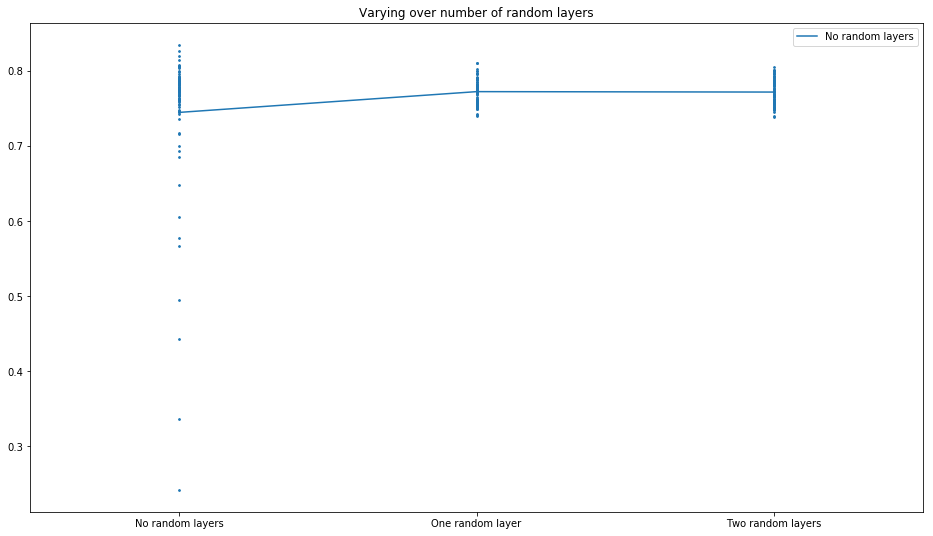

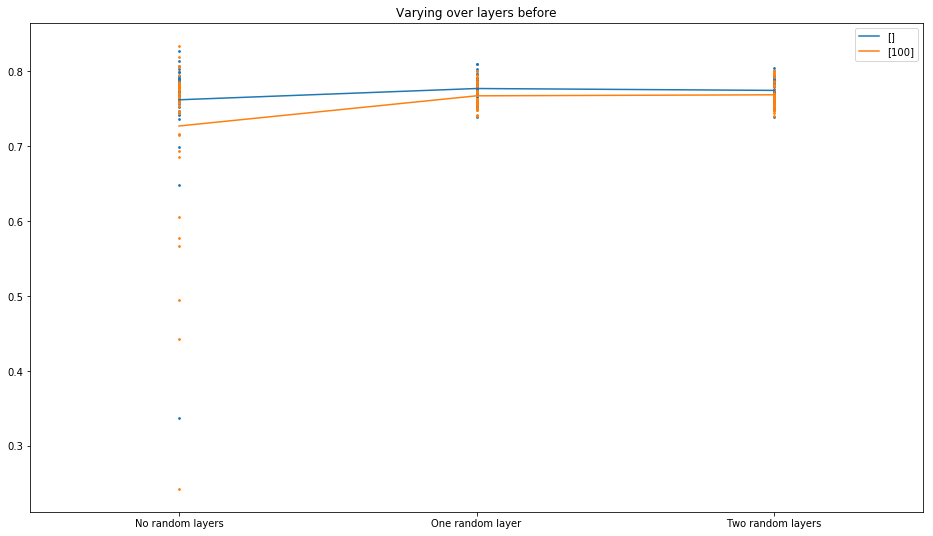

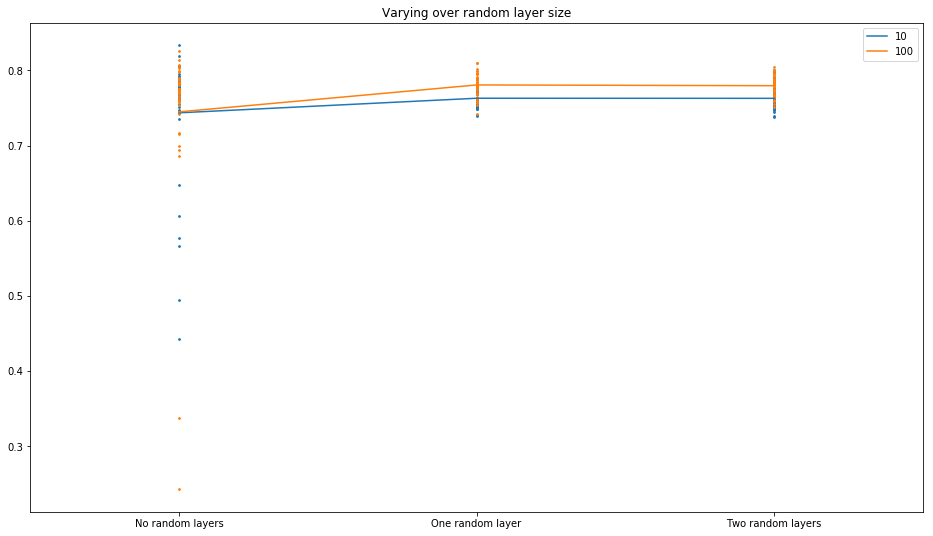

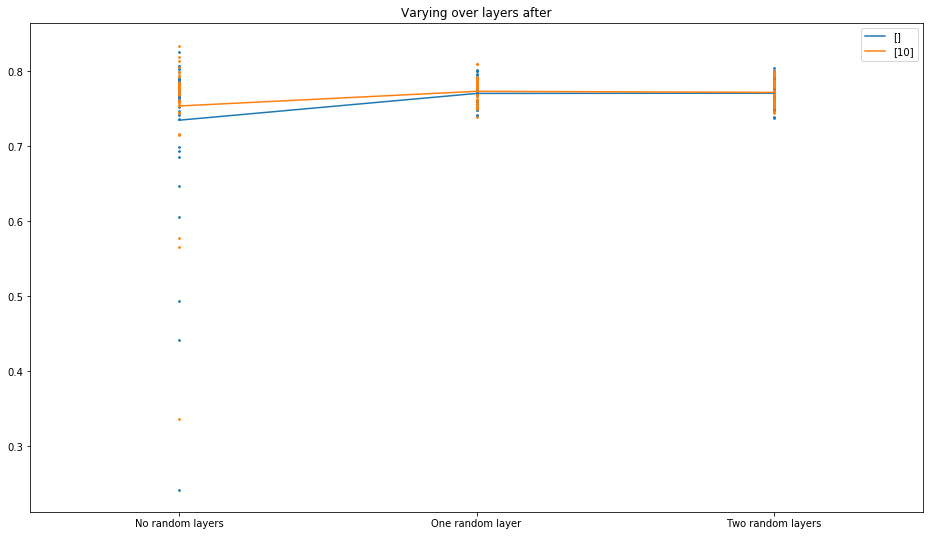

In [20]:
plotter.plot_marginals(
    data,
    dimension_meaning,
    values,
    2
)